# Regression

In this notebook, we calculate the Swiss Army infinitsimal jackknife error bounds for linear regression.

This example illustrates at least one way in which dimension dependence can occur implicitly in the error bound of Theorem 1.

In [1]:
import autograd
import autograd.numpy as np
import scipy as sp
import paragami
import vittles

from tqdm import tqdm 
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A convenience function to visually compare two variables.
def comparison_plot(x, y):
    plt.plot(x, x, 'k')
    plt.plot(x, y, 'r.')

## Generate data and calculate IJ.

First, generate some data according to a linear regression model.

In [3]:
def generate_data(num_obs, dim, sigma):
    """ Generate linear regression data.
    
    Args
    ------
    num_obs: The number of data points
    dim:     The dimension of the regressors
    sigma:   The standard deviation of the residuals
    
    Returns
    --------
    x, y, theta_true: Data y and x for y ~ theta_true * x.
    """
    theta_true = np.linspace(0, 1, dim)
    x = np.random.random((num_obs, dim)) - 0.5
    y = np.random.normal(x @ theta_true, sigma, num_obs)
    return x, y, theta_true

dim = 5
sigma = 0.5
num_obs = dim * 100

x, y, theta_true = generate_data(num_obs, dim, sigma)

First, we specify the weighted regression loss function.  In this case, the optimum is available in closed form.  For convenience we implement the closed form optimum and test that it matches the optimum of the loss function.

In [4]:
def eval_log_loss(theta, w, x, y):
    resid = y - x @ theta
    log_lik = -0.5 * np.sum(w * (resid ** 2)) / num_obs
    return -1 * log_lik

def get_optimum(w, x, y):
    xtx = (w[:, None] * x).T @ x
    xty = (w[:, None] * x).T @ y
    return np.linalg.solve(xtx, xty)

# Test the loss function and optimum with random weights.
w = np.ones(num_obs) + 0.1 * (np.random.random(num_obs) - 0.5)

log_loss_objective = paragami.OptimizationObjective(
    lambda theta: eval_log_loss(theta, w, x, y))

opt = sp.optimize.minimize(
    fun=log_loss_objective.f,
    jac=log_loss_objective.grad,
    hess=log_loss_objective.hessian,
    method='trust-exact',
    x0=theta_true,
    options={'gtol': 1e-12})
print(opt.message)

assert(np.linalg.norm(opt.x - get_optimum(w, x, y)) / dim < 1e-8)

Iter 0: f = 0.12766380
Iter 1: f = 0.12680524
Optimization terminated successfully.


Get the initial optimum at the vector of unity weights.

In [5]:
w1 = np.ones(num_obs)
theta_opt = get_optimum(w1, x, y)

Define an IJ predictor using ``vittles``.

In [6]:
ij_predictor = \
    vittles.HyperparameterSensitivityLinearApproximation(
        lambda theta, w: eval_log_loss(theta, w, x, y),
        opt_par_value=theta_opt,
        hyper_par_value=w1)

Get the IJ predictions and exact CV for a range of weights.

100%|██████████| 500/500 [00:00<00:00, 15637.90it/s]


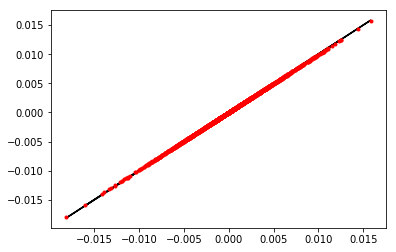

In [7]:
theta_ij = np.full((num_obs, dim), float('nan'))
theta_cv = np.full((num_obs, dim), float('nan'))

ij_time = 0
cv_time = 0

w_loo = np.ones(num_obs)
for n in tqdm(range(num_obs)):
    w_loo[n] = 0
    tic = time.time()
    theta_ij[n, :] = ij_predictor.predict_opt_par_from_hyper_par(w_loo)
    ij_time = ij_time + time.time() - tic

    tic = time.time()
    theta_cv[n, :] = get_optimum(w_loo, x, y)
    cv_time = cv_time + time.time() - tic

    w_loo[n] = 1

comparison_plot(theta_cv - theta_opt[None, :], theta_ij - theta_opt[None, :])

The IJ is faster even than the closed form optimum, though, to be fair, the closed form optimum could be made more efficient by caching $(X^T X)^{-1}$ and using the Woodbury matrix identity.

In [8]:
print('IJ time: {}'.format(ij_time))
print('CV time: {}'.format(cv_time))

IJ time: 0.00426483154296875
CV time: 0.026402711868286133


## Error bound calculation.

Now we calculate bounds on the error of the IJ approximation.  The objective function and its derivatives are

$$
\begin{align}
\ell\left(x_{n},\theta\right)	&=-\frac{1}{2}\left(y_{n}-\theta^{T}x_{n}\right)^{2} \\
g_{n}\left(\theta\right)	&=\left(y_{n}-\theta^{T}x_{n}\right)x_{n} \\
h_{n}\left(\theta\right)	&=-x_{n}x_{n}^{T}. \\
\end{align}
$$

We will define $\Omega_\theta$ as a ball of radius $b$ centered at $\hat\theta$.  The letter $b$ is for "bound".

$$
\Omega_{\theta} =\left\{ \theta: \left\Vert \theta-\hat{\theta} \right\Vert_{2}\le b\right\}.
$$

For notational convenience, we additionally define the following quantities.

$$
\begin{align}
R	=& \frac{1}{N}\sum_{n=1}^{N}y_{n}x_{n}\\
S	=& \frac{1}{N}\sum_{n=1}^{N}x_{n}x_{n}^{T}.
\end{align}
$$


In this notation,

$$
\begin{align}
G\left(\theta\right)	&=
    \frac{1}{N}\sum_{n=1}^{N}\left(y_{n}-\theta^{T}x_{n}\right)x_{n} \\
	&=R-S\theta\\
\end{align}
$$

and



### Assumption 1.

Assumption 1 is certainly satisfied -- indeed, $g_n(\theta)$ is linear.

### Assumption 2.

We have

$$
H\left(\theta\right)	=-S.
$$

Consequently,

$$
C_{op} =1/\lambda_{min}\left(S\right).
$$

In this case, $C_{op}$ is a function of the data alone, and not of the parameter $\theta$.  It can be readily calculated from the data.

### Assumption 3.

We will not require the constants $C_g$ and $C_h$ from assumption 3 here.  As shown below, instead of using Corollary 1, it will be more convienct to control the supremum in Condition 1 directly.

### Assumption 4.

Because $h_n(\theta) = - x_n x_n ^T$ does not depend on $\theta$, we can effectively take $\Delta_\theta = \infty$ and $L_h = 0$.

### Assumption 5.

Because $L_h = 0$, we will not need $C_w$ in this case.

### Condition 1.

We will calculate bounds separately for the gradient and Hessian complexity, called $\delta_g$ and $\delta_h$ respectively, and take 

$$
\delta = \max\{\delta_g, \delta_g\}.
$$

### Condition 1 for the Hessian.

We are considering leave one out, so

$$
\begin{align}
\sup_{w \in W_\delta} \sup_{\theta\in\Omega_{\theta}} 
\left \Vert
\frac{1}{N} (w_n - 1) h_n(\theta)
\right \Vert_1
 = \frac{1}{N} \sup_{n \in [N]} \sup_{\theta\in\Omega_{\theta}}\left\Vert h_{n}\left(\theta\right) \right\Vert_{1}.
\end{align}
$$

Now, 

$$
\begin{align}
\sup_{\theta\in\Omega_{\theta}}\left\Vert h_{n}\left(\theta\right) \right\Vert_{1}
    &=\sup_{\theta\in\Omega_{\theta}}\left\Vert x_{n}x_{n}^{T} \right\Vert_{1} \\
	&=\sum_{d_{1},d_{2}}\left|x_{nd_{1}}x_{nd_{2}}\right| \\
	&=\sum_{d_{1}}\sum_{d_{2}}\left|x_{nd_{1}}\right|\left|x_{nd_{2}}\right| \\
	&=\left\Vert x_{n} \right\Vert_{1}^{2}.
\end{align}
$$

so we define

$$
\delta_h = \frac{1}{N} \sup_{n \in [N]} \left\Vert x_{n} \right\Vert_{1}^{2}
$$

If we were using leave-k-out, one could apply the triangle inequalty to get an upper bound of the sum of the top k values of $\left\Vert x_{n} \right\Vert_{1}^{2}$.


### Condition 1 for the gradient.

As with the Hessian,

$$
\begin{align}
\sup_{w \in W_\delta} \sup_{\theta\in\Omega_{\theta}} 
\left \Vert
\frac{1}{N} (w_n - 1) g_n(\theta)
\right \Vert_1
 = \frac{1}{N} \sup_{n \in [N]} \sup_{\theta\in\Omega_{\theta}}\left\Vert g_{n}\left(\theta\right) \right\Vert_{1}.
\end{align}
$$

Now,

$$
\begin{align}
\sup_{\theta\in\Omega_{\theta}} \left\Vert g_{n}\left(\theta\right) \right\Vert_{1}
    &=\sup_{\theta\in\Omega_{\theta}}
    \left\Vert \left(y_{n} - \theta^{T}x_{n}\right)x_{n} \right\Vert_{1} \\
    &= \left\Vert x_{n} \right \Vert_{1} \sup_{\theta\in\Omega_{\theta}}\left|y_{n}-x_{n}^{T}\theta\right|.
\end{align}
$$

To control this, we need to control each terms' largest residual for $\theta\in\Omega_{\theta}$.  We can get a bound that takes advantage of the fact that $\Omega_\theta$ is centered at $\hat\theta$ as follows:

$$
\begin{align}
\sup_{\theta\in\Omega_{\theta}}\left|y_{n}-x_{n}^{T}\theta\right|	&=
    \sup_{\theta\in\Omega_{\theta}}
        \left|y_{n}-x_{n}^{T}\left(\left(\theta-\hat{\theta}\right)+\hat{\theta}\right)\right|  \\  
&\le \left|y_{n}-x_{n}^{T} \hat{\theta}\right| +
    \sup_{\theta\in\Omega_{\theta}}\left|x_{n}^{T}\left(\theta-\hat{\theta}\right)\right| \\
& \le \left|y_{n}-x_{n}^{T}\hat{\theta}\right| +
     \left\Vert x_{n} \right\Vert_{2}
         \sup_{\theta\in\Omega_{\theta}} \left\Vert \theta-\hat{\theta} \right\Vert_{2} \\
& = \left|y_{n}-x_{n}^{T}\hat{\theta}\right| + \left\Vert x_{n} \right\Vert_{2}b.
\end{align}
$$

Putting this together,

$$
\delta_g = \frac{1}{N} \max_{n \in [N]}
    \left\Vert x_{n} \right \Vert_{1}
        \left( \left|y_{n}-x_{n}^{T}\hat{\theta}\right| + \left\Vert x_{n} \right\Vert_{2}b \right)
$$

Again, if we were using leave-k-out, the triangle inequality would give as a bound the sum of the top k such values.


### Theorem 1.

In this case, with $L_h = 0$ the error bound reduces to

$$
\begin{align}
\delta \le & \frac{1}{2} C_{op}^{-1} \Rightarrow \\
\max_{w \in W_\delta} \left\Vert 
    \hat\theta_{IJ}(w) - \hat\theta(w) \right\Vert_2 \le &
2 C_{op}^2 \delta^2
\end{align}
$$

## A note on dimension dependence in Theorem 1.

In order for Theorem 1 to apply, we must have $\delta \le \Delta_\delta$.  In this case, that means that

$$
\begin{align}
\delta &\le \frac{1}{2} C_{op}^{-1} \Leftrightarrow \\
\frac{1}{N} \max_{n \in [N]} \left( \max \{
    \left\Vert x_{n} \right \Vert_{1}^2 \} ,
    \left\Vert x_{n} \right \Vert_{1}
        \left( \left|y_{n}-x_{n}^{T}\hat{\theta}\right| + \left\Vert x_{n} \right\Vert_{2}b \right)
    \right)
&\le \frac{\lambda_{min}\left(S\right)}{2}  
\end{align}
$$

Depending on the values of $x_n$, this condition is not guaranteed to hold.  In particular, the matrix $S$ may be very nearly singular due to colinearity, e.g., due to having two nearly identical regressors.  In this case, the right hand side would be very small, but the left hand side may not necessarily be small.  And, indeed, in such a case we may not expect the IJ to work well.

More generally, we note that the bound on $\delta$ increases  with the dimension $D$ (roughly linearly if the elements of $x_n$ are IID), but that $C_{op}^{-1}$ may plausibly remain the same or even decrease as dimension increases.  Consequently, for a fixed $N$, as $D$ increases the bound of Theorem 1  eventually may not apply in general.

Even when $\delta \le \Delta_\delta$ and Theorem 1 applies, we certainly expect the bound $C_{op} ^ 2 \delta^2$ to increase as the dimension increases with all else fixed.

# Calculating and checking the bounds.

We now define a functions that calculate and report the error bounds.

In [9]:
def print_error_bounds(ij_error_terms):
    for k, v in ij_error_terms.items():
        print('{:>15} = {}'.format(k, v))


def get_ij_error_bounds(x, y, theta_width):
    num_obs = x.shape[0]
    d = x.shape[1]

    s_mat = x.T @ x / num_obs
    c_op = 1 / np.min(np.linalg.eigvals(s_mat))

    # Because L_h = 0, C_{ij} has a simple form.
    c_ij = 1.0

    x_l1_vec = np.sum(np.abs(x), axis=1)
    x_l2_vec = np.linalg.norm(x, axis=1)
    resid = y - x @ theta_opt

    delta_g = x_l1_vec * (np.abs(resid) + theta_width * x_l2_vec) / num_obs
    delta_h = (x_l1_vec ** 2)  / num_obs

    # It is interesting to know whether the Hessian complexity or
    # gradient complexity is bounding.  This is particuarly true
    # because one could work harder to get a better bound on the gradient
    # complexity if necessary.
    print('Proportion where delta_h dominates: ', np.sum(delta_h > delta_g) / num_obs)

    delta = np.max(np.vstack([delta_g, delta_h]))

    delta_delta = 0.5 / (c_ij * c_op)
    err_bound = 2 * (c_op ** 2) * c_ij * delta ** 2

    ij_error_terms = dict()
    
    ij_error_terms['theta_width'] = theta_width
    ij_error_terms['c_op'] = c_op
    ij_error_terms['d'] = d
    ij_error_terms['delta_h'] = np.max(delta_h)
    ij_error_terms['delta_g'] = np.max(delta_g)
    ij_error_terms['delta'] = delta
    ij_error_terms['delta_delta'] = delta_delta
    ij_error_terms['c_ij'] = c_ij
    ij_error_terms['err_bound'] = err_bound

    if delta > delta_delta:
        print('\n\n#############\nWarning: delta is not small enough to apply theorem 1.\n')
        ij_error_terms['valid'] = False
    else:
        ij_error_terms['valid'] = True

    return ij_error_terms

Let's take a guess at a size for $\Omega_\theta$ based on the asymptotic covariance.

In [10]:
obj_hessian = autograd.hessian(lambda theta: eval_log_loss(theta, w1, x, y))(theta_opt)
theta_cov = np.linalg.inv(num_obs * obj_hessian)
theta_width = 2 * np.max(np.sqrt(np.diag(theta_cov)))

print('Using b = {}'.format(theta_width))

Using b = 0.3158523319701689


In [11]:
# theta_width is b in the derivation.
# Note that, in the regime where the Hessian complexity dominates, changing 
# theta_width has no effect on the error bounds.
theta_width = 5.0

ij_error_terms = get_ij_error_bounds(x, y, theta_width)
print_error_bounds(ij_error_terms)

Proportion where delta_h dominates:  0.0
        delta_h = 0.009138630905725151
    theta_width = 5.0
          valid = True
    delta_delta = 0.036717785329702116
              d = 5
        delta_g = 0.021823815050962876
           c_op = 13.617379030633828
           c_ij = 1.0
          delta = 0.021823815050962876
      err_bound = 0.1766356628910031


First, confirm that $\Omega_\theta$ was chosen to be large enough.

\Omega_{\theta} is big enough to capture the observed changes.


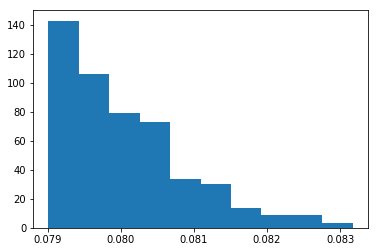

In [12]:
err_bound = ij_error_terms['err_bound']
theta_ij_diff = theta_ij - theta_opt
theta_diff_norm = np.linalg.norm(theta_ij_diff + np.sign(theta_ij_diff) * err_bound, axis=1)
plt.hist(theta_diff_norm / theta_width);
if np.max(theta_diff_norm / theta_width) > 1:
    print('###############\n Warning: \\Omega_\\theta is too small.  The results may not be valid.')
    print('Increase ``theta_width`` and try again.')
else:
    print('\\Omega_{\\theta} is big enough to capture the observed changes.')

We confirm that the error bounds capture the actual errors.  Ideally, the actual errors would be an appreciable proprotion of the error bounds, though this is not always the case.

Error bound ratio (should be less than one):  0.00111628464567661


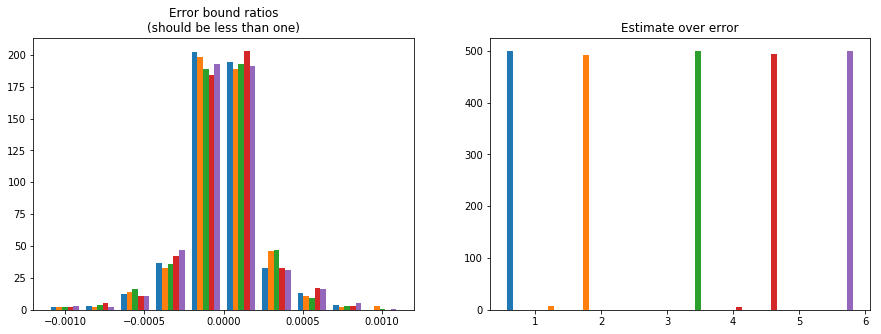

In [24]:
err_bound = ij_error_terms['err_bound']
err = theta_cv - theta_ij

plt.figure(figsize=(15, 5))

if ij_error_terms['valid']:
    plt.subplot(1, 2, 1)
    plt.hist(err / err_bound);
    plt.title('Error bound ratios\n(should be less than one)')
    print('Error bound ratio (should be less than one): ', np.max(np.abs(err / err_bound)))
    plt.subplot(1, 2, 2)
    plt.hist(theta_ij / err_bound);
    plt.title('Estimate over error')
else:
    print('Error bounds are invalid.')
    print('Error bound ratio (should be less than one): ', np.max(np.abs(err / err_bound)))
